# Analyzing outliers from data & Returning Dates

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import numpy as np
import os
import time
from itertools import chain


##### ETF Data Clean up ###########

class ETFDataCleanup(object):
    
    def __init__(self):
        pass

    def showNaColumns(self,df):
        s=df.isnull().sum()
        print(s[s>0])
    
    def dropNAColumns(self,df):
        return df.dropna(axis='columns')
    
    def computeDailyReturns(self,df):
        return df.pct_change().dropna()        
    
    
####### Get Data for Constituents of ETF

class ConstituentsData(ETFDataCleanup):
    
    def __init__(self,fileName=None,startdate=None,enddate=None):
        self.fileName=fileName
        self.startdate=startdate
        self.enddate=enddate
        self.constituentdata=[]
        self.constituentcloseDF=[]
        self.tickerdf=[]
        self.changeDF=[]
        self.waDF=[]
    
    def getconstituentdata(self):
        self.tickerdf = pd.read_excel(self.fileName)
        tickers=self.tickerdf['Ticker']
        self.tickerdf.set_index('Ticker',inplace=True)
        self.constituentdata =  web.DataReader(tickers,'yahoo',self.startdate,self.enddate)
        self.constituentcloseDF = self.constituentdata['Close'].iloc[:, :]
        
    def stringWeightsToFloat(self):
        self.tickerdf['Weights']=self.tickerdf['Weights'].apply(lambda x: x.replace('%','')).astype(float)
    
    def findNetAssetValue(self):
        self.waDF=self.changeDF
        for col in self.changeDF.columns:
            # Divide by 100 for weights percentage eg 23.28%
            self.waDF[col]=self.changeDF[col]*self.tickerdf['Weights'].loc[col]/100
        self.waDF['NAV']=self.waDF.sum(axis=1)

####### Get prices of ETF        
class ETFStockPrices(ETFDataCleanup):
    
    def __init__(self,etfticker=None,startdate=None,enddate=None):
        self.etfticker=etfticker
        self.startdate=startdate
        self.enddate=enddate
        self.etfdata=[]
        self.etfchangeDF=[]

        
    def getETFTickerData(self):
        self.etfdata =  web.DataReader(self.etfticker,'yahoo',self.startdate,self.enddate)
 


class ETFArbitrage(object):

    def __init__(self,etfob,waDF):
        self.navDF=pd.merge(etfob,waDF['NAV'],left_index=True,right_index=True)
        self.navDF['Date']=self.navDF.index
        self.navDF['Close']=self.navDF['Close']*100
        self.navDF['NAV']=self.navDF['NAV']*100
        del self.navDF['Date']
    
    def scatterplot(self):
        plt.scatter(self.navDF['Close'],self.navDF['NAV'])
        
    def scatterplot2(self):
        #change figure size for the plot
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0]=12
        fig_size[1]=6
        plt.rcParams["figure.figsize"]=fig_size

        self.navDF['Mispricing']=(self.navDF['Close']-self.navDF['NAV'])
        plt.scatter(self.navDF.index,self.navDF['Mispricing'])
    
    def seaborndist(self):
        sns.distplot(self.navDF['Mispricing'].values, hist=True, kde=True, 
             bins='auto', color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
        
class ZscoreAnlysByAttr():
    def __init__(self,data,attribute,ticker,zthresh):
        self.df=[]
        self.requiredDF=[]
        self.data=data
        self.attribute=attribute
        self.ticker=ticker
        self.zthresh=zthresh
    def getMispricedData(self):
        self.df=self.data[self.attribute,self.ticker].to_frame()
        self.df['Z-Score']=np.abs(stats.zscore(self.df.values.tolist()))
        self.requiredDF=self.df[self.df['Z-Score']>self.zthresh]
        return self.requiredDF

# Load any ETF you want

XLK
Tickers with NA Values
Symbols
NLOK    65
dtype: int64
***************
Check for NA Values again
Series([], dtype: int64)
***************
Data for Constituents
Symbols         AAPL      MSFT         V      INTC        MA      CSCO  \
Date                                                                     
2019-01-02  0.000235 -0.000862  0.000395  0.000140  0.000250 -0.000266   
2019-01-03 -0.020489 -0.007159 -0.001917 -0.002410 -0.001949 -0.001326   
2019-01-04  0.008781  0.009051  0.002292  0.002688  0.002046  0.001365   
2019-01-07 -0.000458  0.000248  0.000959  0.000204  0.000332  0.000205   
2019-01-08  0.003921  0.001411  0.000289  0.000277  0.000239  0.000245   

Symbols         ADBE       CRM      NVDA      PYPL  ...        WU      JKHY  \
Date                                                ...                       
2019-01-02 -0.000190 -0.000254  0.000465  0.000411  ...  0.000008 -0.000031   
2019-01-03 -0.001019 -0.000931 -0.001378 -0.000888  ... -0.000028 -0.000041   
2

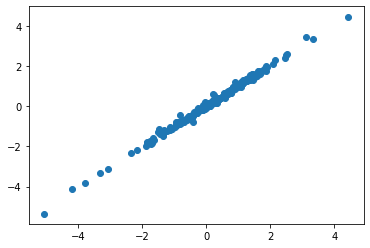

/home/piyush/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


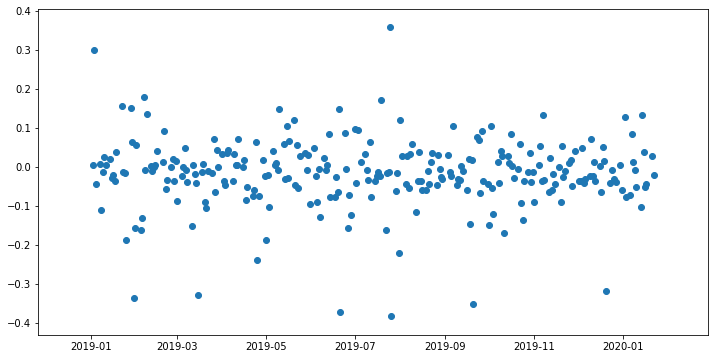

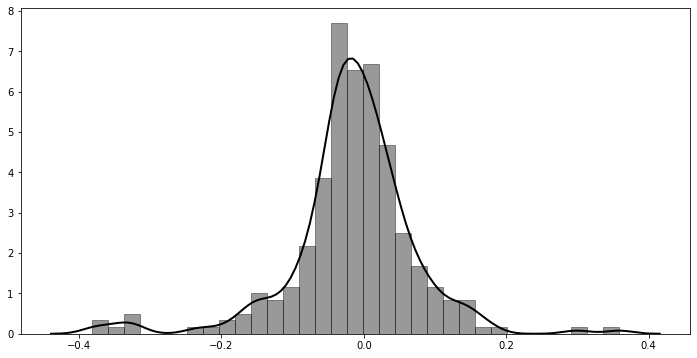

In [2]:
tickeretf="XLK"

filename='ETFDailyData'+'/'+dt.datetime.now().strftime("%Y%m%d")+'/'+tickeretf+'.xls'
startdate=dt.datetime(2019,1,1)
enddate=dt.datetime(2020,1,22)

ob=ConstituentsData(fileName=filename,startdate=startdate,enddate=enddate)
ob.getconstituentdata()
print(tickeretf)
print("Tickers with NA Values")
ob.showNaColumns(ob.constituentcloseDF)
ob.constituentcloseDF=ob.dropNAColumns(ob.constituentcloseDF)
print("***************")
print("Check for NA Values again")
ob.showNaColumns(ob.constituentcloseDF)
ob.changeDF=ob.computeDailyReturns(ob.constituentcloseDF)
ob.stringWeightsToFloat()
ob.findNetAssetValue()

print("***************")
print("Data for Constituents")
print(ob.waDF.head(5))

etfob=ETFStockPrices(etfticker=tickeretf,startdate=dt.datetime(2019,1,1),enddate=dt.datetime(2020,1,22))
etfob.getETFTickerData()
print("Show Any Empty Values")
etfob.showNaColumns(etfob.etfdata)
etfob.etfchangeDF=etfob.computeDailyReturns(etfob.etfdata['Close'])

print("***************")
print("Data for ETF stock prices")
print(etfob.etfchangeDF.head(5))

print("****************")
print("Charts")
arbob=ETFArbitrage(etfob.etfchangeDF,ob.waDF)
arbob.scatterplot()
plt.show()
arbob.scatterplot2()
plt.show()
arbob.seaborndist()
plt.show()

# List down all objects of 3 different classes

In [3]:
print("Constituents Data Objects")
print(dir(ob))

print("*************************")
print("ETF Price Object")
print(dir(etfob))

print("*************************")
print("Arbitrage Data Object")
print(dir(arbob))

Constituents Data Objects
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'changeDF', 'computeDailyReturns', 'constituentcloseDF', 'constituentdata', 'dropNAColumns', 'enddate', 'fileName', 'findNetAssetValue', 'getconstituentdata', 'showNaColumns', 'startdate', 'stringWeightsToFloat', 'tickerdf', 'waDF']
*************************
ETF Price Object
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'compute

In [4]:
print(arbob.navDF.head(5))

               Close       NAV  Mispricing
Date                                      
2019-01-02  0.064538  0.058661    0.005877
2019-01-03 -5.046761 -5.345812    0.299051
2019-01-04  4.431993  4.476503   -0.044511
2019-01-07  0.894308  0.886728    0.007579
2019-01-08  0.838035  0.948878   -0.110843


## Z-Score Method

In [5]:
tempChangeDf=ob.changeDF*100
del tempChangeDf['NAV']
tempChangeDf=round(tempChangeDf,4)

In [6]:
# Calculate Z-Score for the Mispricing Column
arbob.navDF['Z-Score'] = np.abs(stats.zscore(arbob.navDF['Mispricing']))

In [7]:
negmovers=[]
posmovers=[]

for col in tempChangeDf.T:
    values=(tempChangeDf.T[col].sort_values())
    negmovers.append(dict(values[:3]))
    posmovers.append(dict(values[(len(values)-3):]))

    
arbob.navDF['Top negmovers']=negmovers
arbob.navDF['Top posmovers']=posmovers    

In [8]:
arbob.navDF

,Close,NAV,Mispricing,Z-Score,Top negmovers,Top posmovers
Date,,,,,,
2019-01-02,0.064538,0.058661,0.005877,0.237540,"{'MSFT': -0.0862, 'CSCO': -0.0266, 'CRM': -0.0...","{'V': 0.0395, 'PYPL': 0.0411, 'NVDA': 0.0465}"
2019-01-03,-5.046761,-5.345812,0.299051,3.534734,"{'AAPL': -2.0489, 'MSFT': -0.7159, 'INTC': -0....","{'XRX': -0.0022, 'ADS': -0.0018, 'DXC': 0.0005}"
2019-01-04,4.431993,4.476503,-0.044511,0.329146,"{'FTNT': -0.0024, 'WU': 0.0023, 'ANET': 0.0027}","{'INTC': 0.2688, 'AAPL': 0.8781, 'MSFT': 0.9051}"
2019-01-07,0.894308,0.886728,0.007579,0.256684,"{'AAPL': -0.0458, 'ADP': -0.0061, 'QCOM': -0.0...","{'CRM': 0.0757, 'V': 0.0959, 'NVDA': 0.1207}"
2019-01-08,0.838035,0.948878,-0.110843,1.075160,"{'NVDA': -0.0568, 'AMAT': -0.034, 'AVGO': -0.0...","{'CRM': 0.0603, 'MSFT': 0.1411, 'AAPL': 0.3921}"
...,...,...,...,...,...,...
2020-01-15,0.115693,0.076598,0.039095,0.611128,"{'AAPL': -0.0882, 'INTC': -0.0361, 'AVGO': -0....","{'MA': 0.0502, 'V': 0.1018, 'MSFT': 0.126}"
2020-01-16,1.344678,1.395335,-0.050657,0.398274,"{'CDW': -0.0008, 'LDOS': 0.0003, 'ADS': 0.0005}","{'MA': 0.0832, 'AAPL': 0.2577, 'MSFT': 0.3566}"
2020-01-17,0.673786,0.717466,-0.043680,0.319801,"{'CDW': -0.0148, 'HPE': -0.0119, 'ORCL': -0.0095}","{'V': 0.0993, 'MSFT': 0.1089, 'AAPL': 0.2277}"


# Show me days with Arbitrage Opportunities

In [9]:
daysofarbitrage=arbob.navDF[arbob.navDF['Z-Score']>3]

In [10]:
daysofarbitrage

,Close,NAV,Mispricing,Z-Score,Top negmovers,Top posmovers
Date,,,,,,
2019-01-03,-5.046761,-5.345812,0.299051,3.534734,"{'AAPL': -2.0489, 'MSFT': -0.7159, 'INTC': -0....","{'XRX': -0.0022, 'ADS': -0.0018, 'DXC': 0.0005}"
2019-01-30,3.108003,3.442405,-0.334402,3.589418,"{'JNPR': -0.0091, 'MXIM': -0.0024, 'GLW': -0.002}","{'AMD': 0.1596, 'MSFT': 0.6503, 'AAPL': 1.4056}"
2019-03-15,0.884588,1.212627,-0.328039,3.517858,"{'ADBE': -0.1022, 'ORCL': -0.0036, 'FTNT': -0....","{'AVGO': 0.1573, 'MSFT': 0.2242, 'AAPL': 0.2676}"
2019-06-21,-0.823204,-0.453151,-0.370053,3.990372,"{'AAPL': -0.0701, 'PYPL': -0.0452, 'MA': -0.0376}","{'ADSK': 0.0057, 'ADI': 0.0062, 'INTC': 0.0251}"
2019-07-25,-0.410872,-0.769537,0.358665,4.205186,"{'AAPL': -0.1627, 'PYPL': -0.106, 'MSFT': -0.0...","{'GPN': 0.0193, 'FISV': 0.0242, 'FIS': 0.025}"
2019-07-26,0.218411,0.600923,-0.382512,4.130490,"{'INTC': -0.0479, 'XLNX': -0.0182, 'ADSK': -0....","{'FISV': 0.0641, 'AAPL': 0.0715, 'MSFT': 0.1596}"
2019-09-20,-1.473112,-1.123101,-0.350011,3.764967,"{'AAPL': -0.3007, 'MSFT': -0.2249, 'MA': -0.0742}","{'NOW': 0.0081, 'CSCO': 0.0253, 'CRM': 0.0255}"
2019-12-20,0.253523,0.571976,-0.318453,3.410052,"{'AAPL': -0.0426, 'AVGO': -0.0301, 'CSCO': -0....","{'V': 0.0416, 'INTC': 0.0748, 'MSFT': 0.2125}"


In [11]:
newDF=ob.constituentdata['Volume','AAPL']
newDF.describe()


count    2.670000e+02
mean     2.826609e+07
std      1.062305e+07
min      1.136200e+07
25%      2.109725e+07
50%      2.619210e+07
75%      3.244115e+07
max      9.131220e+07
Name: (Volume, AAPL), dtype: float64

In [12]:
max=newDF.describe()[1]+(3*newDF.describe()[2])
min=newDF.describe()[1]-(3*newDF.describe()[2])
print(min, max)

-3603065.904174991 60135253.91915626


In [13]:
# By Volume
newDF=ob.constituentdata['Volume','AAPL'].to_frame()
newDF['Z-Score'] = np.abs(stats.zscore(newDF.values.tolist()))
#temp[temp['Z-Score']>thresoldStandrdDeviation]
requiredDF=newDF[newDF['Z-Score']>3]
requiredDF.head()

,Volume,Z-Score
,AAPL,
Date,,
2019-01-03,91312200.0,5.945984
2019-01-30,61109800.0,3.097545
2019-05-01,64827300.0,3.448149
2019-07-31,69281400.0,3.868222
2019-12-20,68994500.0,3.841164


In [14]:
ob.constituentdata.columns.levels[0]

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Attributes')

In [15]:
# By Close
newerDF=ob.constituentdata['Close','AAPL'].to_frame().pct_change()
newerDF['Z-Score']=np.abs(stats.zscore(newerDF.values.tolist()))
#print(newerDF)
newerrequiredDF=newerDF[newerDF['Z-Score']>2]
newerrequiredDF

,Close,Z-Score
,AAPL,
Date,,


In [16]:
#By Volume using Class
zs=ZscoreAnlysByAttr(ob.constituentdata,'Volume','AAPL',3)
reqVDF=zs.getMispricedData()
reqVDF

,Volume,Z-Score
,AAPL,
Date,,
2019-01-03,91312200.0,5.945984
2019-01-30,61109800.0,3.097545
2019-05-01,64827300.0,3.448149
2019-07-31,69281400.0,3.868222
2019-12-20,68994500.0,3.841164


In [17]:
#By Close using Class
zs=ZscoreAnlysByAttr(ob.constituentdata.pct_change(),'Close','AAPL',2)
reqCDF=zs.getMispricedData()
reqCDF

,Close,Z-Score
,AAPL,
Date,,
